In [1]:
import time
start_time = time.time()

In [2]:
import logging
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

from dask.distributed import Client

import lotka_volterra
import utils.caching
from utils.caching import cached
from utils.ksd import calculate_ksd
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.paths import FIGURES_PATH, GENERATED_DATA_PATH
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

Directory where results of expensive calculations will be stored:

In [5]:
utils.caching.cache_dir = GENERATED_DATA_PATH

In [6]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [7]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32987,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:35603,Total threads: 4
Dashboard: http://127.0.0.1:46725/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:34361,


In [8]:
map_parallel = get_map_parallel(client)

In [9]:
n_chains = len(lotka_volterra.theta_inits)

Read-only input datasets:

In [10]:
@cached(item_type=np.ndarray, batch_size=n_chains, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplemented

In [11]:
@cached(item_type=np.ndarray, batch_size=n_chains, read_only=True)
def hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

# Naive thinning

The baseline for comparison is the naive thinning approach where we retain each $i$-th element of the sample.

In [12]:
def naive_thin(sample_size, thinned_size):
    return np.linspace(0, sample_size - 1, thinned_size).astype(int)

In [13]:
@cached()
def rw_naive_idx(i: int) -> np.ndarray:
    return naive_thin(rw_samples[i].shape[0], n_points_thinned)

In [14]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_naive_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_naive_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_naive_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_3
DEBUG:utils.

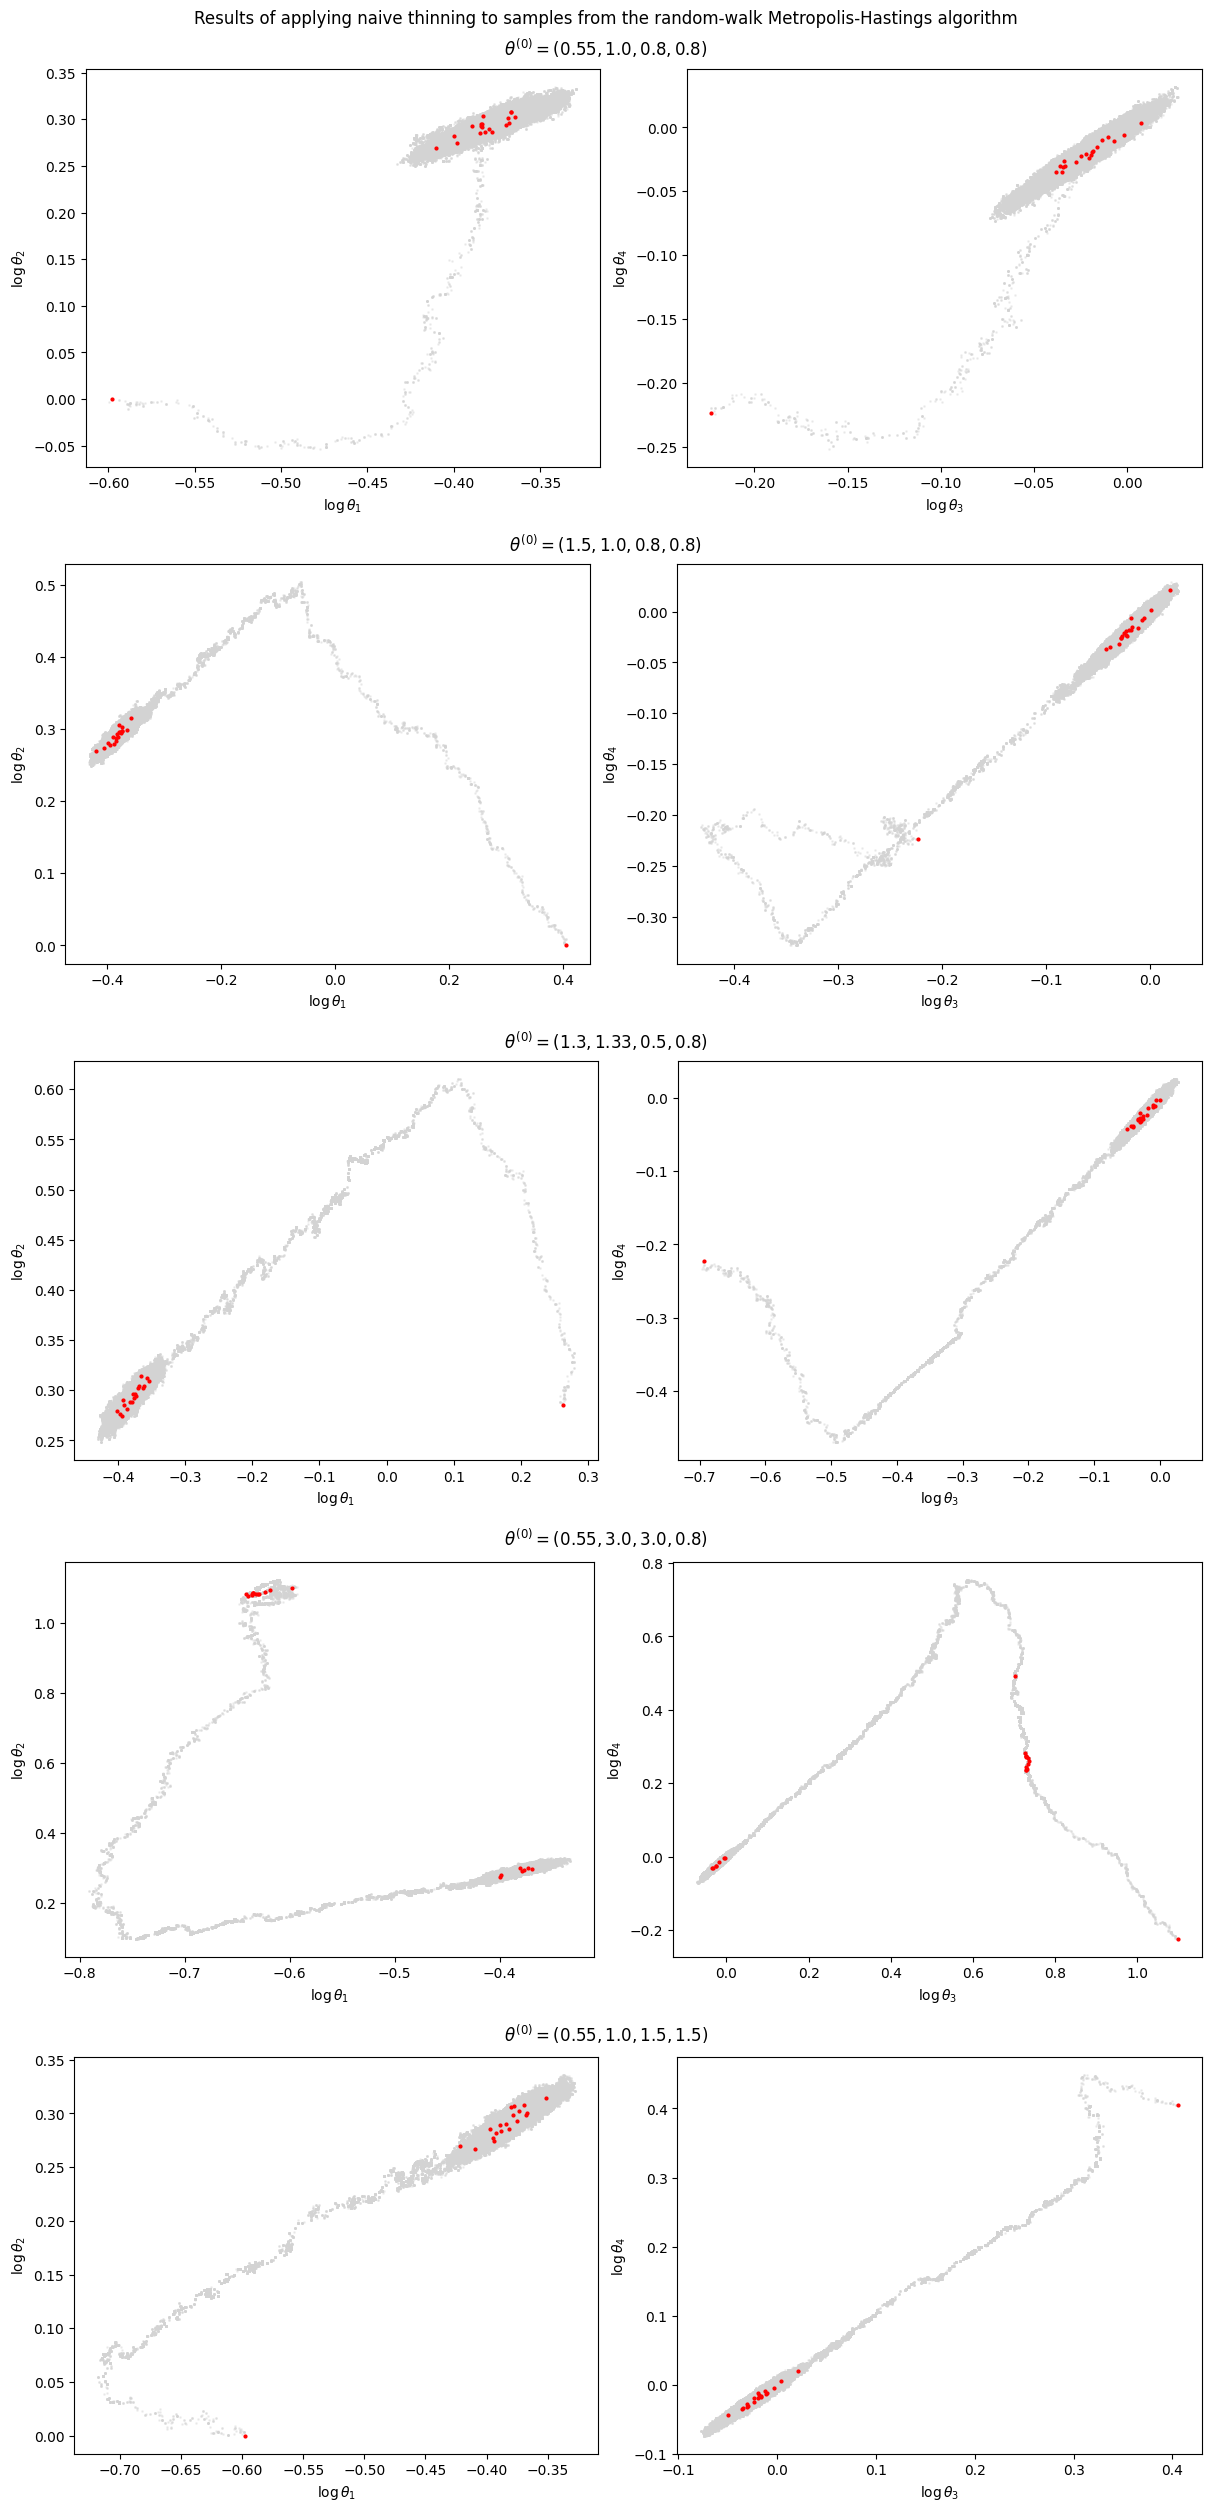

In [15]:
fig = plot_sample_thinned(rw_samples, rw_naive_idx, titles, var_labels);
fig.savefig(FIGURES_PATH / 'lotka-volterra-naive-thinning.png', dpi=300);
fig.suptitle('Results of applying naive thinning to samples from the random-walk Metropolis-Hastings algorithm');

Notebook execution took:

In [16]:
time.time() - start_time

25.87164282798767